In [1]:
! nvcc --version
# !cat /usr/local/cuda-9.0/include/cudnn.h | grep CUDNN_MAJOR -A 2

In [2]:
import tensorflow as tf
# !cat /usr/local/cuda-9.0/include/cudnn.h | grep CUDNN_MAJOR -A 2
tf.__version__

'1.8.0'

In [3]:
import sys
import os
import cv2
import time
import glob
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

train_folder = 'Dataset/train'
val_folder = 'Dataset/validation'
test_folder = 'Dataset/test'

def _minmax_scaler(data):
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    
    return numerator / (denominator + 1e-7)


def _one_hot(idx):
    idx = tf.one_hot(np.array(idx), 12).eval(session=tf.Session())
    
    return idx

def _shuffle(images, labels):
    tmp = [[x,y] for x, y in zip(images, labels)]
    random.shuffle(tmp)
    shuffle_images = [n[0] for n in tmp]
    shuffle_labels = [n[1] for n in tmp]
    
    return shuffle_images, shuffle_labels

def _data_load(folder_path):
    images = []
    labels = []
    folder_list = os.listdir(folder_path)
    for i, v in enumerate(folder_list):
        image_path = glob.glob(os.path.join(folder_path,v,'*.png')) 
        for j in image_path:
            images.append(cv2.imread(j))
            labels.append(i)
        
    return _minmax_scaler(images), _one_hot(labels)


train_images, train_labels = _data_load(train_folder)
val_images, val_labels = _data_load(val_folder)
test_images, test_labels = _data_load(test_folder)

print("train_images shape: ", np.array(train_images).shape, "// type: ", type(np.array(train_images)))
print("train_labels shape: ", np.array(train_labels).shape, "// type: ", type(np.array(train_labels)))
print("validation_images shape: ", np.array(val_images).shape, "// type: ", type(np.array(val_images)))
print("validation_labels shape: ", np.array(val_labels).shape, "// type: ", type(np.array(val_labels)))
print("test_images shape: ", np.array(test_images).shape, "// type: ", type(np.array(test_images)))
print("test_labels shape: ", np.array(test_labels).shape, "// type: ", type(np.array(test_labels)))

train_images shape:  (3847, 64, 64, 3) // type:  <class 'numpy.ndarray'>
train_labels shape:  (3847, 12) // type:  <class 'numpy.ndarray'>
validation_images shape:  (447, 64, 64, 3) // type:  <class 'numpy.ndarray'>
validation_labels shape:  (447, 12) // type:  <class 'numpy.ndarray'>
test_images shape:  (456, 64, 64, 3) // type:  <class 'numpy.ndarray'>
test_labels shape:  (456, 12) // type:  <class 'numpy.ndarray'>


In [4]:
learning_rate = 0.00001
batch_size = 64
n_epochs = 100

# Create placeholders
X = tf.placeholder(tf.float32,shape=[None,64,64,3], name="image")
Y = tf.placeholder(tf.int32,[None, 12], name="label")
#Y = tf.one_hot(Y, 12).eval(session=tf.Session())
#Y1 = tf.one_hot(Y, 12)
#Y2 = tf.reshape(Y1, [-1, 12])

#64x64x64
Kernel1_1 = tf.get_variable("Kernel1_1",shape=[3,3,3,64],initializer=tf.contrib.layers.xavier_initializer())
Bias1_1 = tf.Variable(tf.truncated_normal(shape=[64],stddev=0.1))
Conv1_1 = tf.nn.conv2d(X, Kernel1_1, strides=[1,1,1,1], padding='SAME')+Bias1_1
Activation1_1 = tf.nn.relu(Conv1_1)

#64x64x64
Kernel1_2 = tf.get_variable("Kernel1_2",shape=[3,3,64,128],initializer=tf.contrib.layers.xavier_initializer())
Bias1_2 = tf.Variable(tf.truncated_normal(shape=[128],stddev=0.1))
Conv1_2 = tf.nn.conv2d(Activation1_1, Kernel1_2, strides=[1,1,1,1], padding='SAME')+Bias1_2
Activation1_2 = tf.nn.relu(Conv1_2)

#32x32x128
Pool1 = tf.nn.max_pool(Activation1_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#32x32x256
Kernel2_1 = tf.get_variable("Kernel2_1",shape=[3,3,128,256],initializer=tf.contrib.layers.xavier_initializer())
Bias2_1 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.1))
Conv2_1 = tf.nn.conv2d(Pool1, Kernel2_1, strides=[1,1,1,1], padding='SAME')+Bias2_1
Activation2_1 = tf.nn.relu(Conv2_1)

#32x32x256
Kernel2_2 = tf.get_variable("Kernel2_2",shape=[3,3,256,256],initializer=tf.contrib.layers.xavier_initializer())
Bias2_2 = tf.Variable(tf.truncated_normal(shape=[256],stddev=0.1))
Conv2_2 = tf.nn.conv2d(Activation2_1, Kernel2_2, strides=[1,1,1,1], padding='SAME')+Bias2_2
Activation2_2 = tf.nn.relu(Conv2_2)

#16x16x256
Pool2 = tf.nn.max_pool(Activation2_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#16x16x512
Kernel3_1 = tf.get_variable("Kernel3_1",shape=[3,3,256,512],initializer=tf.contrib.layers.xavier_initializer())
Bias3_1 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv3_1 = tf.nn.conv2d(Pool2, Kernel3_1, strides=[1,1,1,1], padding='SAME')+Bias3_1
Activation3_1 = tf.nn.relu(Conv3_1)

#16x16x512
Kernel3_2 = tf.get_variable("Kernel3_2",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias3_2 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv3_2 = tf.nn.conv2d(Activation3_1, Kernel3_2, strides=[1,1,1,1], padding='SAME')+Bias3_2
Activation3_2 = tf.nn.relu(Conv3_2)

#8x8x512
Pool3 = tf.nn.max_pool(Activation3_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#8x8x512
Kernel4_1 = tf.get_variable("Kernel4_1",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias4_1 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv4_1 = tf.nn.conv2d(Pool3, Kernel4_1, strides=[1,1,1,1], padding='SAME')+Bias4_1
Activation4_1 = tf.nn.relu(Conv4_1)

#8x8x512
Kernel4_2 = tf.get_variable("Kernel4_2",shape=[3,3,512,512],initializer=tf.contrib.layers.xavier_initializer())
Bias4_2 = tf.Variable(tf.truncated_normal(shape=[512],stddev=0.1))
Conv4_2 = tf.nn.conv2d(Activation4_1, Kernel4_2, strides=[1,1,1,1], padding='SAME')+Bias4_2
Activation4_2 = tf.nn.relu(Conv4_2)

#4x4x512
Pool4 = tf.nn.max_pool(Activation4_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#4x4x1024
## Add DCNN Layer 1
Kernel5_1 = tf.get_variable("Kernel5_1",shape=[3,3,512,1024],initializer=tf.contrib.layers.xavier_initializer())
Bias5_1 = tf.Variable(tf.truncated_normal(shape=[1024],stddev=0.1))
Conv5_1 = tf.nn.conv2d(Pool4, Kernel5_1, strides=[1,1,1,1], padding='SAME')+Bias5_1
Activation5_1 = tf.nn.relu(Conv5_1)

#4x4x1024
## Add DCNN Layer 2
Kernel5_2 = tf.get_variable("Kernel5_2",shape=[3,3,1024,1024],initializer=tf.contrib.layers.xavier_initializer())
Bias5_2 = tf.Variable(tf.truncated_normal(shape=[1024],stddev=0.1))
Conv5_2 = tf.nn.conv2d(Activation5_1, Kernel5_2, strides=[1,1,1,1], padding='SAME')+Bias5_2
Activation5_2 = tf.nn.relu(Conv5_2)

#2x2x1024
Pool5 = tf.nn.max_pool(Activation5_2, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

#2x2x2048
## Add DCNN Layer 3
Kernel6_1 = tf.get_variable("Kernel6_1",shape=[3,3,1024,2048],initializer=tf.contrib.layers.xavier_initializer())
Bias6_1 = tf.Variable(tf.truncated_normal(shape=[2048],stddev=0.1))
Conv6_1 = tf.nn.conv2d(Pool5, Kernel6_1, strides=[1,1,1,1], padding='SAME')+Bias6_1
Activation6_1 = tf.nn.relu(Conv6_1)

#2x2x2048
## Add DCNN Layer 4
Kernel6_2 = tf.get_variable("Kernel6_2",shape=[3,3,2048,2048],initializer=tf.contrib.layers.xavier_initializer())
Bias6_2 = tf.Variable(tf.truncated_normal(shape=[2048],stddev=0.1))
Conv6_2 = tf.nn.conv2d(Activation6_1, Kernel6_2, strides=[1,1,1,1], padding='SAME')+Bias6_2
Activation6_2 = tf.nn.relu(Conv6_2)

#2x2x2048
Pool6 = tf.nn.max_pool(Activation6_2, ksize=[1,2,2,1],strides=[1,1,1,1],padding='SAME')

#2x2x2048
## Add DCNN Layer 5
Kernel7_1 = tf.get_variable("Kernel7_1",shape=[3,3,2048,2048],initializer=tf.contrib.layers.xavier_initializer())
Bias7_1 = tf.Variable(tf.truncated_normal(shape=[2048],stddev=0.1))
Conv7_1 = tf.nn.conv2d(Activation6_2, Kernel7_1, strides=[1,1,1,1], padding='SAME')+Bias7_1
Activation7_1 = tf.nn.relu(Conv7_1)

#2x2x2048
## Add DCNN Layer 6
Kernel7_2 = tf.get_variable("Kernel7_2",shape=[3,3,2048,2048],initializer=tf.contrib.layers.xavier_initializer())
Bias7_2 = tf.Variable(tf.truncated_normal(shape=[2048],stddev=0.1))
Conv7_2 = tf.nn.conv2d(Activation7_1, Kernel7_2, strides=[1,1,1,1], padding='SAME')+Bias7_2
Activation7_2 = tf.nn.relu(Conv7_2)

#2x2x2048
## Add DCNN Layer 7
Kernel7_3 = tf.get_variable("Kernel7_3",shape=[3,3,2048,2048],initializer=tf.contrib.layers.xavier_initializer())
Bias7_3 = tf.Variable(tf.truncated_normal(shape=[2048],stddev=0.1))
Conv7_3 = tf.nn.conv2d(Activation7_2, Kernel7_3, strides=[1,1,1,1], padding='SAME')+Bias7_3
Activation7_3 = tf.nn.relu(Conv7_3)

#1x1x2048
Pool7 = tf.nn.max_pool(Activation7_3, ksize=[1,2,2,1],strides=[1,2,2,1],padding='SAME')

W1 = tf.get_variable("W1",shape=[1*1*2048, 2048],initializer=tf.contrib.layers.xavier_initializer())
B1 = tf.Variable(tf.truncated_normal(shape=[2048]))
Pool7_flat = tf.reshape(Pool7,[-1,1*1*2048])
fc8 = tf.matmul(Pool7_flat,W1)+B1
Activation8 = tf.nn.relu(fc8)

W2 = tf.get_variable("W2",shape=[2048, 12],initializer=tf.contrib.layers.xavier_initializer())
B2 = tf.Variable(tf.truncated_normal(shape=[12]))
OutputLayer = tf.matmul(Activation8 ,W2)+B2

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=OutputLayer, labels=Y))
#optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9).minimize(loss)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)

correct_prediction = tf.equal(tf.argmax(OutputLayer,1),tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction,tf.float32))

In [5]:
# Run optimization and test
loss_train_history = []
acc_train_history = []
loss_val_history = []
acc_val_history = []

init = tf.global_variables_initializer()

with tf.Session() as sess:
    sess.run(init)
    n_batches = int(len(train_images)/batch_size)
    
    for i in range(n_epochs):  
        total_correct_train_preds = 0
        x_train, y_train =_shuffle(train_images, train_labels)
        for k in range(n_batches):
            X_train_batch, Y_train_batch = x_train[k*batch_size:k*batch_size+batch_size], \
                                           y_train[k*batch_size:k*batch_size+batch_size] 
            _, loss_train, OutputLayer_train_batch = sess.run([optimizer, loss, accuracy], \
                                                              feed_dict={X: X_train_batch, Y: Y_train_batch})
            total_correct_train_preds += OutputLayer_train_batch
        train_accuracy = total_correct_train_preds/n_batches
                
        
        # Check validation accuracy
        n_v_batches = int(len(val_images)/batch_size)
        total_correct_val_preds = 0
        for j in range(n_v_batches):
            X_val_batch, Y_val_batch = val_images[j*batch_size:j*batch_size+batch_size], \
                                       val_labels[j*batch_size:j*batch_size+batch_size] 
            loss_val, OutputLayer_val_batch = sess.run([loss, accuracy], feed_dict={X: X_val_batch, \
                                                                                    Y: Y_val_batch})
            total_correct_val_preds += OutputLayer_val_batch
        validation_accuracy = total_correct_val_preds/n_v_batches
           
        print('epoch:%d // train loss:%.3f // train accuracy:%.3f // val loss:%.3f // val accuracy:%.3f' \
              % (i, loss_train, train_accuracy, loss_val, validation_accuracy))
        loss_train_history.append(loss_train)
        acc_train_history.append(train_accuracy)
        loss_val_history.append(loss_val)
        acc_val_history.append(validation_accuracy)
        
        


    # Test the model
    n_batches = int(len(test_images)/batch_size)
    total_correct_test_preds = 0
    for i in range(n_batches):
        X_test_batch, Y_test_batch = test_images[i*batch_size:i*batch_size+batch_size], \
                                     test_labels[i*batch_size:i*batch_size+batch_size]
        OutputLayer_test_batch = sess.run(OutputLayer, feed_dict={X: X_test_batch, Y:Y_test_batch})
        preds = tf.nn.softmax(OutputLayer_test_batch)
        correct_preds = tf.equal(tf.argmax(preds, 1), tf.argmax(Y_test_batch, 1))
        accuracy = tf.reduce_sum(tf.cast(correct_preds, tf.float32))
        total_correct_test_preds += sess.run(accuracy)
        
    print ("Test accuracy is {0}".format(total_correct_test_preds/len(test_images)))


epoch:0 // train loss:2.436 // train accuracy:0.119 // val loss:2.223 // val accuracy:0.109
epoch:1 // train loss:2.388 // train accuracy:0.141 // val loss:2.230 // val accuracy:0.109
epoch:2 // train loss:2.418 // train accuracy:0.139 // val loss:2.174 // val accuracy:0.109
epoch:3 // train loss:2.411 // train accuracy:0.130 // val loss:2.181 // val accuracy:0.135
epoch:4 // train loss:2.437 // train accuracy:0.132 // val loss:2.344 // val accuracy:0.135
epoch:5 // train loss:2.327 // train accuracy:0.139 // val loss:2.226 // val accuracy:0.135
epoch:6 // train loss:2.358 // train accuracy:0.138 // val loss:2.178 // val accuracy:0.109
epoch:7 // train loss:2.479 // train accuracy:0.136 // val loss:2.259 // val accuracy:0.109
epoch:8 // train loss:2.432 // train accuracy:0.136 // val loss:2.319 // val accuracy:0.109
epoch:9 // train loss:2.381 // train accuracy:0.133 // val loss:2.291 // val accuracy:0.135
epoch:10 // train loss:2.481 // train accuracy:0.133 // val loss:2.379 // val ac

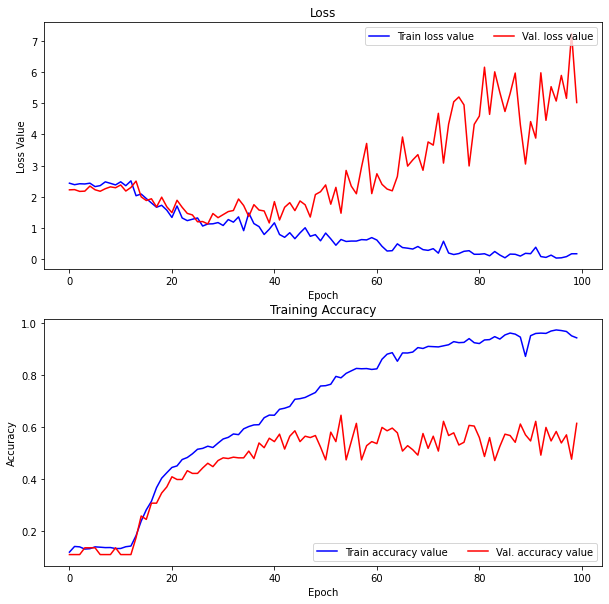

In [6]:
plt.subplot(2,1,1)
plt.plot(loss_train_history, 'b-', label='Train loss value')
plt.plot(loss_val_history, 'r-', label='Val. loss value')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.legend(ncol=2, loc='upper right')

plt.subplot(2,1,2)
plt.plot(acc_train_history, 'b-', label='Train accuracy value')
plt.plot(acc_val_history, 'r-', label='Val. accuracy value')
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(10, 10)
plt.show()